## Batch update multiple XML files

This is a Jupyter Notebook to batch process the GeMS metadata templates for use with the metadata tools in the 3.0 version of the GeMS Tools toolbox. For templates for your project, copy the folder of GeMS-default templates, `gems-atbx\resources\metadata\templates`, and then proceed through this notebook adding project-specific language as necessary. Note that one step below WILL re-write the template files in place. All others modify in-memory copies before writing them to an output directory.

Many operations here make use of some XML functions written for the USGS Metadata Wizard which are included in the file `xml_utils.py`. If you have the GeMS Toolbox, this file can be found in the `scripts` directory of the toolbox directory. You can also use the file that is included with the USGS Metadata Wizard if you have that installed. In either case, you need to append a path to `sys.path` before importing the file:

1. Using the copy included with the GeMS Tools toolbox - browse to the directory with the toolbox and copy the path to the folder named `scripts`.

2. Using the copy included with USGS Metadata Wizard - find the installation folder of the app (often `C:\Users\myusername\MetadataWizard` but if not, you will have to search for it or inspect the properties of a shortcut). From there, copy the full path to `MetadataWizard\fort-pymdwizard\pymdwizard\core`

3. Save the path to the variable `scripts_dir` in the **Imports** section below. Note that if the path delimiter is just one backslash (`\`), as would be the case when copying the path from the address bar in Windows Explorer, add an `r` in front of the quotes of the string (eg, `r"C:\GIS\Toolboxes\gems-tools-pro"`). But if you drag-and-drop the path into the notebook from the Catalog pane in ArcGIS Pro, the backslashes are 'escaped', that is, doubled, and the `r` is unnecessary. [More about backslashes](https://www.pythontutorial.net/python-basics/python-backslash/).

Finally, it should be noted, there is one other option. If you have Metadata Wizard installed, you can launch Jupyter from within Metadata Wizard and then open this notebook (look at the example notebooks mentioned below for how to import the Metadata Wizard utilities). Metadata Wizard is installed with an entire instance of python with all of the special dependencies needed to run it, including an instance of Jupyter. It's a little heavy for our purposes here and because it turns out that we only need one additional file for operations in this notebook and not everyone will want to install Metadata Wizard, I simply copied `xml_utils.py` into the GeMS Tools toolbox. Using just this file makes this Notebook environment-agnostic and it should work with nearly any instance of Python 3.

It may be useful to first read through a Jupyter Notebook included with Metadata Wizard called **pymdwizard scripting (Start Here).ipynb** which can be found in `MetadataWizard\fort-pymdwizard\examples` or [online](https://github.com/DOI-USGS/fort-pymdwizard/blob/master/examples/pymdwizard%20scripting%20(Start%20Here).ipynb).

## Contents

The internal links here don't work for me in ArcGIS Pro for some reason; only if the notebook is opened through a different Jupyter server. I recommend using Visual Studio Code.

[Imports](#imports)  
[Functions](#functions)  
[XPaths and the XMLRecord dot notation](#xpaths)  
[Start with a folder of XML files](#start)  
[Find and replace text in the input file](#findreplace)  
[Make a python dictionary of file and XMLRecord](#records)  
[Read the title for each record](#read_title)  
[Read any attribute based on the xpath](#read_attr)  
[Remove new-line and tab characters in element text](#remove_nl)  
[Use custom entity-attribute definition file](#my_defs)  
[Remove extraneous fields](#remove_fields)  
[Tokens](#tokens)  
[Edit titles using tokens](#edit_title)  
[Edit multiple elements from a dictionary](#edit_from_dict)  
[Spatial elements](#spatial)  
[Add a spdom element](#spdom)  
[Add a metadata contact element](#metc)  
[Sorting keywords](#sort_kw)  
[Sorting Entity nodes](#sort_ents)  
[Sorting Attribute nodes](#sort_attrs)  
[Sorting source info by publication date](#sort_source)  
[Sorting process steps by date](#sort_prcstep)  
[Save templates to new files](#save)

<a id='imports'></a>

## Imports

In [1]:
import sys
# add some paths to folders inside the GeMS Tools toolbox directory.
scripts = "C:\\AAA\\gems\\gitspace\\gems-atbx\\scripts"
sys.path.append(scripts)
    
import xml_utils as xu
import metadata_utilities as mu
from pathlib import Path
from itertools import islice
import csv
from dateutil import parser
import copy

from importlib import reload

In [2]:
# some constant paths. Set these for your location of the GeMS Tools toolbox
resources = "C:\\AAA\\gems\\gitspace\\gems-atbx\\resources"
md_resources = "C:\\AAA\\gems\\gitspace\\gems-atbx\\resources\\metadata"

<a id='functions'></a>

## Functions

In [8]:
def find_attr(obj, attr):
    """Return an attribute of an object given a dot-delimited
    string representation of the path to the attribute"""
    attrs = attr.split(".")
    for a in attrs:
        try:
            obj = getattr(obj, a)
        except AttributeError:
            obj = None
            
    return obj

In [9]:
def extend_branch(record, x_path):
    """Builds out a branch incrementally if the full xpath does not yet exist
    if 'record' is an XMLRecord (has the attribute metadata), we'll select the 
    metadata node and go from there. Otherwise, 'record' will really be an XMLNode
    Does not work for branches that have elements that XMLRecord returns as lists"""
    # parameter node always starts with 'metadata' so start searching for attributes at 
    # index = 1 after splitting
    if hasattr(record, "metadata"):
        node = record.metadata
    else:
        node = record

    for attr in x_path.split("."):
        if getattr(node, attr, None):
            node = getattr(node, attr)
        else:
            node.add_child(xu.XMLNode(tag=attr))
            node = getattr(node, attr)
    return node

In [10]:
def take(n, iterable):
    """Return the first n items of the iterable as a list."""
    return list(islice(iterable, n))

<a id='xpaths'></a>

## XPaths and the XMLRecord dot notation

Every node or element in an XML record can be navigated to by its so-called XPath which is the chain of node names leading to it, e.g., `metadata/idinfo/citation/citeinfo` or `metadata/eainfo/detailed/enttyp/enttypl`. Within the FGDC-CSDGM XML schema, the node names in the xpath are shortened or abbreviated forms of more readable names like `Citation_Information` or `Entity_Type_Label`, respectively, which you normally see in the text version of an XML metadata record. When an XML file has been converted into an XMLRecord by `xml_utils.py`, those XPaths are accessible through so-called dot notation. For example, say we create an XMLRecord from a file:

`md = xu.XMLRecord("C:\path\to\metadata.xml")`

We could then access the `citeinfo` node through dot notation:

`cite_info = md.metadata.idinfo.citation.citeinfo`

Intellisense in ArcGIS Pro or VS Code should show you a list of attributes available at any one attribute:

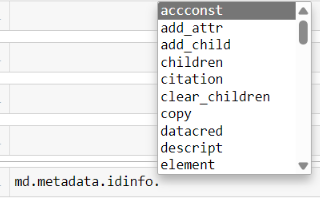

as well as a number of methods available through `xml_utils`.

In the `resources/metadata` folder of the GeMS Tools toolbox is a file called `long_name_xpath.txt` which shows the long name for each CSDGM element, indented according to hierarchy, followed by the full dot-notated xpath. You can look an element name up in that file and copy the xpath for use in this Notebook. 

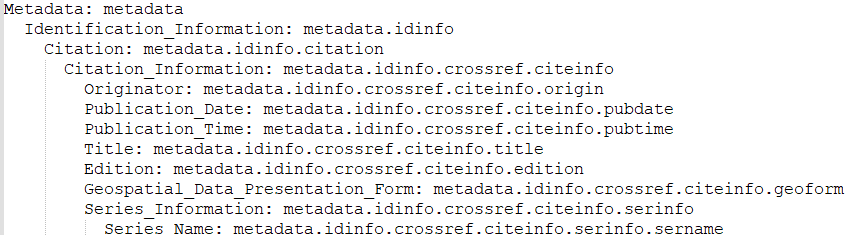

Note that you can paste the xpath directly to a variable for an XMLRecord, e.g.,

`print(md.metadata.idinfo.citation.citeinfo.title.text)` 

or you can use the `find_attr` function above and pass it the XMLRecord and a string representation of the xpath, e.g.,

```
my_el = "metadata.idinfo.citation.citeinfo.title"
print(find_attr(xml_record, my_el).text.
```

The latter is a bit easier when iterating through many records because you can save the string to a shorter variable.

It is possible I did not add all elements. If that's the case, you will have to refer to the [schema](https://www.fgdc.gov/csdgmgraphical/index.html) (though older, this link is to my preferred documentation of the schema) and work it out from scratch.

Note that some elements are returned as lists, `keywords` being a good example. In that case, to get a pointer to a specific child node, you will have to specify an index; for example:

`metadata.idinfo.keywords.theme.themekey[2]` retrieves the third `Theme_Keyword` in the list.

In [ ]:
# print out the contents of long_name_xpath.txt
with open(Path(md_resources) / "long_name_xpath.txt") as f:
    for line in f.readlines():
        print(line.strip('\n'))

<a id='start'></a>

## Start with a folder of XML files

In [ ]:
# copy r"path\to\GemsTools\resources\metadata\templates" to another
# folder and set temps_folder below
#temps_folder = Pat"C:\\AAA\\gems\\gitspace\\gems-atbx\\resources\\metadata\\templates"
temps_folder = "C:\\AAA\\gems\\gitspace\\gems-atbx\\resources\\metadata\\templates"

# print the list of the xml files there
for f in Path(temps_folder).glob('*.xml'):
    print(f.name)

<a id='findreplace'></a>

## Find and replace text in the input file

Here's a simple way to find and replace text in the XML files using `fileinput` which allows you to edit in place while iterating over a collection of files.

Unlike the other steps in this notebook, which make changes to an in-memory copy of the files that you can inspect before finally writing it to a file, this step will make changes to the input file iteself. If you have any concern about recovering the original in the case of a mistake, make a copy first using the `backup` parameter of `fileinput.FileInput`

In [ ]:
import fileinput
# look for enttypds and attrdefs elements
gems = "GeMS (Geologic Map Schema) - a standard format for the digital publication of geologic maps, available at http://ngmdb.usgs.gov/Info/standards/GeMS/"
tags = ("enttypds", "attrdefs", "codesets")
for p in Path(temps_folder).glob('*.xml'):
    # use 'backup=".bak"' to make a copy of the original or remove that parameter if you are confident of the edit
    # with fileinput.FileInput(p, inplace=True, backup=".bak") as f:
    with fileinput.FileInput(p, inplace=True) as f:
        for line in f:
            found = False
            for tag in tags:
                old_def = f"<{tag}>GeMS</{tag}>"
                if old_def in line: 
                    new_def = f"<{tag}>{gems}</{tag}>"
                    print(line.replace(old_def, new_def), end ='') 
                    found = True
            if not found:
                print(line, end ='') 

<a id="records"></a>

## Make a python dictionary of file and XMLRecord

In [21]:
# make a dictonary of file names and the XMLRecord created from the file by xml_utils
records = {f.stem: xu.XMLRecord(f) for f in Path(temps_folder).glob('*.xml')}

# for k, v in records.items():
#     # print out the .__class__ "magic" attribute of the value to check that the XMLRecord was created
#     print(k, v.__class__)

<a id='read_title'></a>

## Read the title for each record

In [ ]:
# the generic_template.xml has two title elements because it can be used as a generic template
# for both 'report' level metadata describing everything in the database in one record
# or for 'single' level metadata that describes only one table.
# At each record you could find the title by 
el_path = "metadata.idinfo.citation.citeinfo.title"
for k, v in records.items():
    print(k)
    el = find_attr(v, el_path)
    if type(el) == list:
        for n in el:
            print(n.text)
    else:
        print(el.text)

<a id='read_attr'></a>

## Read any attribute based on the xpath

Find the xpath in `long_name_xpath.txt` for any element you want to see the text for, copy it, and paste it into `el_path` below.

In [ ]:
el_path = "metadata.eainfo.detailed.enttyp.enttypd"
for k, v in records.items():
    print(k)
    el = find_attr(v, el_path)
    if type(el) == list:
        for n in el:
            if n.text:
                print(n.text)
            else:
                print("None")
    else:
        if el:
            print(el.text)
        else:
            print("None")

<a id='remove_nl'></a>

## Remove new-line and tab characters in element text

The templates I am starting with have a lot of tab and new-line characters in free-text elements, which look ok when the XML has been pretty-printed and displayed in a text editor with a narrow window, but I think in general you should not try to format the text inside of XML files because it is hard to predict how the whitespace will be interpreted by a translator (to HTML, for example) or in a text editor. To remove all of these, the simplest thing is to run `.split()` on the entire file, rebuild with `' '.join()`, and then convert to a new XMLRecord to insert the correct indentations and new-line characters only after closing XML tags. If you have any formatting you want preserved such as paragraph breaks or bullet-like lists, don't run this step; that will all be clobbered.

In [22]:
for k, v in records.items():
    xml_str = str(v._contents)
    xml_str = ' '.join(xml_str.split())
    records[k] = xu.XMLRecord(xml_str)

In [ ]:
# confirm this worked with a couple records
for key, value in take(3, records.items()):
    print(key, value)

<a id="my_defs"></a>

## Use custom entity-attribute definition file

When using the `Collate Metadata Sources` tool, you can supply a CSV file containing the definitions for custom tables and fields to automate the writing of Entity_Attribute sections. An example called `my_definitions.csv` is supplied with the toolbox in the `resources` folder. In this section, we'll read a customized definitions file and use it to populate the template files. You can also add use this file to add attributes to entity sections that do not already exist, although only fields associated with specific named tables will be evaluated. Those listed after the `ANY_TABLE` tag (see the documentation in the header of the file) will not.

There are a couple functions in `metadata_utilities.py` that I wrote that read the contents of a definitions file into a couple dictionaries; one for tables and one for fields.

For some reason, the code in this section does not work after other sections that also work on `detailed` elements have run. It's some weird memory issue that I solved in other cells that make copies of `detailded` elements but was unable to do so here. 

In [19]:
# read the contents of the file for context
my_defs = Path(md_resources) / "gems_ea_definitions.csv"
# with open(my_defs, 'r') as f:
#     for line in f.readlines():
#         print(line.strip('\n'))

In [20]:
table_defs = mu.table_defs_from_csv(my_defs)
field_defs = mu.field_defs_from_csv(my_defs)

In [21]:
# run through the records looking for tables and fields defined in the definitions file
for k, v in records.items():
    print(k)
    try:
        detaileds = v.metadata.eainfo.detailed
        if detaileds and not type(detaileds) == list:
            detaileds = [detaileds]
    except AttributeError:
        detaileds = []

    for detailed in detaileds:
        if enttypl := find_attr(detailed, "enttyp.enttypl"):
            if enttypl.text in table_defs:
                tbl_name = enttypl.text
                # look for a table definition in table_defs
                tbl_def = table_defs[tbl_name][0]
                def_src = table_defs[tbl_name][1]
                extend_branch(detailed, "enttyp.enttypd").text = tbl_def
                extend_branch(detailed, "enttyp.enttypds").text = def_src

            # collect a list of fields from field_defs for this table
            field_list = []
            if enttypl.text in field_defs:
                field_list = [n for n in field_defs[tbl_name]]
                
            #  extend field_list to include ANY_TABLE fields  
            if "ANY_TABLE" in field_defs:
                field_list.extend(field_defs["ANY_TABLE"])

            # proceed only if we have custom field definitions
            if field_list:
                attrs = find_attr(detailed, "attr")
                for attr in attrs:
                    attrlabl = find_attr(attr, "attrlabl")
                    for field_item in field_list:
                        if attrlabl.text == field_item[0]:
                            extend_branch(attr, "attrdef").text = field_item[1]
                            extend_branch(attr, "attrdefs").text = field_item[2]

                            # check for domain information
                            if len(field_item) > 3:
                                dom_text = field_item[3]
                                if dom_text == "rdom":
                                    dom_vals = field_item[4].split(",")
                                    extend_branch(attr, "attrdomv.rdom.rdommin").text = dom_vals[0].strip()
                                    extend_branch(attr, "attrdomv.rdom.rdommax").text = dom_vals[1].strip()
                                    extend_branch(attr, "attrdomv.rdom.attrunit").text = dom_vals[2].strip()
                                    extend_branch(attr, "attrdomv.rdom.attrrmres").text = dom_vals[3].strip()
                                    
                                if dom_text == "edom":
                                    for edom in field_item[4].split("|"):
                                        # can't use def extend_branch for multiple elements (when XMLRecord)
                                        # would return a list of elements
                                        dom_vals = edom.split(",")
                                        attrdomv_str = f"""
                                        <attrdomv>
                                            <edom>
                                                <edomv>{dom_vals[0].strip()}</edomv>
                                                <edomvd>{dom_vals[1].strip()}</edomvd>
                                                <edomvds>{dom_vals[2].strip()}</edomvds>
                                            </edom>
                                        </attrdomv>
                                        """
                                        attr.add_child(xu.XMLNode(attrdomv_str))

                                if dom_text == "codestd":
                                    dom_vals = field_item[4].split(",")
                                    extend_branch(attr, "attrdomv.codesetd.codesetn").text = dom_vals[0].strip()
                                    extend_branch(attr, "attrdomv.codesetd.codesets").text = dom_vals[1].strip()
                                    
                                if dom_text == "udom":
                                    extend_branch(attr, "attrdomv.udom").text = field_item[4]


Anno
GeMS_ANY_TABLE-metadata


In [ ]:
# print a the detailed section of a couple records to see that this worked
for k, v in take(2, records.items()):
    print(k)
    print(v.metadata.eainfo.detailed)
    print("\n")

<a id='remove_fields'></a>

## Remove extraneous fields

The `Collate FGDC Metadata` tool does not add attribute (field) information from a template for fields that do not exist in the table, but you may still want to remove extraneous fields from the templates.

In [26]:
# remove the Editor Tracking fields if they exist. 
# I would argue that they don't belong in published databases.
del_attr = ["created_user", "created_date", "last_edited_user", "last_edited_date"]
for k, v in records.items():
    try:
        # try to make an object of all detailed nodes. There is one detailed node per table
        detaileds = v.metadata.eainfo.detailed
        # XMLRecord saves single attributes as an XMLNode but multiple XMLNodes are saved as a list of XMLNodes.
        # If there is just one node, we will convert it to a list of one item so that we don't have to test
        # and can use a for loop regardless of whether there is one node or multiple
        if detaileds and not type(detaileds) == list:
            detaileds = [detaileds]
    except AttributeError:
        detaileds = None

    if detaileds:
        for detailed in detaileds:
            if hasattr(detailed, "attr"):
                # make a copy of all attr nodes
                attrs = copy.deepcopy(detailed.attr)

                # remove them from original
                # see footnote about clear_children and del if you care why there are two 
                # lines that seem to do the same thing
                detailed.clear_children(tag="attr")
                del detailed.attr

                # filter the list of attr elements
                add_attrs = [n for n in attrs if not n.attrlabl.text.lower() in del_attr]
                
                # add the filtered list of attr back
                for add_attr in add_attrs:
                    detailed.add_child(add_attr)

In [ ]:
# print out a couple records to see that this worked:
for k, v in take(2, records.items()):
    print(k)
    try:
        detaileds = v.metadata.eainfo.detailed
        if detaileds and not type(detaileds) == list:
            detaileds = [detaileds]
    except AttributeError:
        detaileds = None

    if detaileds:
        for detailed in detaileds:
            try:
                attrs = detailed.attr
                for attr in attrs:
                    print("  " + attr.attrlabl.text)
            except:
                pass

<a id='tokens'></a>

## Tokens

A few of the GeMS metadata tools recognize some special "token" words that are placeholders for programmatically derived values. The full set is:

```
[[CONTENTS]]: a high-level summary of the contents of the geodatabase
[[VERBOSE CONTENTS]]: a longer summary listing names of objects and some basic relationships between tables in a GeMS database.
[[DATABASE]]: the name of the database file
[[DTYPE]]: the data type of a database object
[[FEATURE DATASET]]: f"This {data_type} is found within the {fd} feature dataset"
[[GEMS]]: "GeMS (Geologic Map Schema)--a standard format for the digital publication of geologic maps", available at http://ngmdb.usgs.gov/Info/standards/GeMS/
[[OBJECT]]: the name of a table or feature class
[[SCRIPT]]: the version string of a script
[[X]]: the code of a line of cross-section, ie CS[[X]] becomes CSA
```

You can put the token in a template file where you want information to be automatically added. Because the GeMS templates are named after GeMS-defined objects but can be applied to custom named objects, e.g., you can use a template for `ContactsAndFaults` for `SurficialContactsAndFaults`.

<a id='edit_title'></a>

## Edit titles using tokens

The titles in the set of templates I am starting with all take the form of "Feature dataset ContactsAndFaults, part of Metadata Template" or "Non-spatial table Glossary, part of Metadata Template". I want to keep the two-word designation of the data type, replace the name with `[[OBJECT]]` so we can work with customized names, and replace "Metadata Template" with `[[DATABASE]]`. 

I could save every title as "[[DATATYPE]] [[OBJECT]], part of [[DATABASE]]", but I like the idea of the data type being saved explicitly in each template for reference when being edited.

In [28]:
# the form that I want of Supplemental Information starts off similar to Title, so we'll write that too
for k, v in records.items():
    if not k == "generic_template":
        orig_title = v.metadata.idinfo.citation.citeinfo.title.text
        words = orig_title.split(" ")
        new_title = f"{words[0]} {words[1]} [[OBJECT]], part of [[DATABASE]]"
        supplinf = f"{words[0]} {words[1]} [[OBJECT]] is part of [[DATABASE]], a composite dataset that conforms to [[GeMS]]. [[FEATURE DATASET]]. This file was partially automated by the use of [[SCRIPT]]."
        v.metadata.idinfo.citation.citeinfo.title.text = new_title
        v.metadata.idinfo.descript.supplinf.text = supplinf
        records[k] = v

In [ ]:
# confirm this worked with a few records
for key, value in take(5, records.items()):
    print(value.metadata.idinfo.citation.citeinfo.title.text)

<a id='edit_from_dict'></a>

## Edit multiple elements using a python dictionary

Use a dictionary to save the text values for several nodes. Find the xpath of each node you want to change in `long_name_xpath.txt` and then write out the value for it. For this step to work, the node must be unique, that is, the xpath can't return a list of nodes. I don't have many to keep track of in the default GeMS templates, but you may want to add much more project-specific text. If the node does not already exist in the record, the code below will create it.

If you find it easier to keep track of template language in a CSV or Excel file, you can do that too and then read the two appropriate columns into a dictionary. There is an example in `resources/metadata` called `change_nodes.csv`. The second cell below has code for that. Use the cell directly below or the next one before running the third.

Note that in this step, depending on when you decide to run it, `eainfo.overview` will be inserted into `eainfo` in the wrong order; it should follow `detailed` sections. Don't worry about that too much in your templates because mp can re-sort elements into the correct order.

In [30]:
# edit the content of change_nodes here
change_nodes = {
     "metadata.dataqual.attracc.attraccr" : "Confidence that a feature exists and confidence that a feature is correctly identified are described in per-feature attributes ExistenceConfidence and IdentityConfidence.",
     "metadata.dataqual.posacc.horizpa.horizpar" : "Estimated accuracy of horizontal location is given on a per-feature basis by attribute LocationConfidenceMeters. Values are expected to be correct within a factor of 2.  A LocationConfidenceMeters value of -9 or -9999 indicates that no value has been assigned.",
     "metadata.idinfo.accconst" : "None",
     "metadata.idinfo.useconst" : "None",
     "metadata.eainfo.overview.eaover" : "[[VERBOSE CONTENTS]]",
     "metadata.eainfo.overview.eadetcit" : "[[GeMS]]"
 }

In [31]:
# OR read in the contents from a CSV (change_nodes.csv in /resources/metadata is an example that
# has the same content as in the cell above
change_file = Path(md_resources) / "change_nodes.csv"
change_nodes = {}
with open(change_file, 'r') as file:
    reader = csv.reader(file)
    next(reader)
    for row in reader:
        change_nodes[row[0]] = row[1]
#print(change_nodes)

In [32]:
# go through the dictionary and make the changes
for n, r in records.items():
    for k, v in change_nodes.items():
        node = extend_branch(r, k)
        node.text = v.strip()

In [ ]:
# confirm this worked with a few records
for key, value in take(2, records.items()):
    print(key, value)

<a id='spatial'></a>

## Spatial elements

The spatial elements in metadata are usually best left to being automatically generated from the inherent properties of feature classes so my recommendation is to remove them from template files. This also makes the templates more generic for use with multiple projects but if you have special requirements, you can write those elements yourself.

You remove children with the `clear_children` method.

In [92]:
# remove all spatial elements from all templates
# we'll use a dictionary of the name of the element to remove and its parent
remove = [
    "metadata.idinfo.spdom",
    "metadata.spdoinfo",
    "metadata.spref",
]

# add more entries to the remove dictionary as necessary for any elements you want cleared
# the function rgetattr converts strings, even dot-nested names, to attributes of the object
# we'll chop up the paths in remove to get the name of the child to remove 
# and a path to it's parent
for record in records.values():
    for el in remove:
        chunks = el.split(".")
        parent_path = ".".join(chunks[:-1])
        child = chunks[-1]
        parent = find_attr(record, parent_path)
        parent.clear_children(tag=child)

In [ ]:
# confirm this worked with a couple records
for key, value in take(2, records.items()):
    print(key, value)

<a id='spdom'></a>

## Add a spdom element

The spatial element you may want to add to all templates is the `Spatial_Domain` or `spdom` element because the calculated coordinates will probably never be exactly the same as those for a particular quadrangle that defines a mapping project. You could add each node one at a time, but an easier way is to convert a string to an XMLNode and then add it to the parent node.

In [ ]:
# add the appropriate numbers to the four variables below
westbc = 1
eastbc = 2
northbc = 3
southbc = 4

# save an xml-formatted string to a variable
add_spdom = f"""
<spdom>
  <bounding>
    <westbc>{westbc}</westbc>
    <eastbc>{eastbc}</eastbc>
    <northbc>{northbc}</northbc>
    <southbc>{southbc}</southbc>
  </bounding>
</spdom>
"""

#turn that into an XMLNode
spdom = xu.XMLNode(add_spdom)

# run through the records, filtering out non-spatial tables and the GeoMaterialDict
# and add the spdom element
for k, r in records.items():
    if not k == "generic_template":
        title = r.metadata.idinfo.citation.citeinfo.title.text
        if not any(n in title for n in ("Non-spatial table", "GeoMaterialDict")):
            r.metadata.idinfo.add_child(spdom)

In [ ]:
# confirm this worked with a couple records
for key, value in take(2, records.items()):
    print(key, value)

<a id='metc'></a>

## Add a metadata contact element

Like the spatial domain element, this is best saved as a string that is converted to an `XMLNode`.

Note that the CSDGM schema [requires](https://www.fgdc.gov/csdgmgraphical/metaref/mcntact/cntact.htm) a Contact Person Primary (`cntperp`) OR a Contact Organization Primary (`cntorgp`) under the `cntinfo` node.

Use

```
<cntorgp>
    <cntorg></cntorg>
    <cntper></cntper>
</cntorgp>
```
OR
```
<cntperp>
  <cntper></cntper>
  <cntorg></cntorg>
</cntperp>
```

In [565]:
# add values to the required nodes
metc_str = """
<metc>
  <cntinfo>
    <cntorgp>
        <cntorg></cntorg>
        <cntper></cntper>
    </cntorgp>
    <cntpos></cntpos>
    <cntaddr>
      <addrtype></addrtype>
      <address></address>
      <city></city>
      <state></state>
      <postal></postal>
      <country></country>
    </cntaddr>
    <cntvoice></cntvoice>
    <cnttdd></cnttdd>
    <cntfax></cntfax>
    <cntemail></cntemail>
    <hours></hours>
    <cntinst></cntinst>
  </cntinfo>
</metc>
"""

In [566]:
# make an XMLNode
metc = xu.XMLNode(metc_str)

# run through the records, filtering out GeoMaterialDict (the metadata contact for this record should be the GeMS group, gems@usgs.gov)
for k, v in records.items():
    if not k == "GeoMaterialDict":
        metainfo = extend_branch(v, "metadata.metainfo")
        metainfo.add_child(metc)

<a id='sort_kw'></a>

## Sorting keywords

Sorting keywords is tricky because of a few things:
1. There are four classes of keywords; `theme, place, stratum, temporal`, which we will sort according to the order shown in CSDGM documentation and in tkme
2. Each class can have keywords organized by multiple thesaurusi, which we want sorted
3. Finally, we want to sort the keywords themselves

It would be interesting, especially given we are working with geologic data, to sort `temporal` temporally, but for that we need a lookup list for reference and we would need to be confident that the keywords matched the terms in that list. Maybe later!

There is a function in `metadata_utilities` that I wrote to make a python dictionary of the entire keywords nest of elements, but it needs to be passed an XML Element Tree so we'll convert the XMLRecord to that first.

One other wrinkle: the key word classes or types, whatever they should be called, exist as XML elements with tags with the terms `<theme>, <place>, <stratum>, <temporal>`. One child to every class element is an element that identifies the thesaurus being used for that particular group of keywords. These elements have the tags `<themekt>, <placekt>, <stratkt>, <tempkt>`, meaning that when creating elements from scratch, we can't just use one list of terms. We have to have two to accommodate for `stratum` and `temporal` being truncated to `strat` and `temp` for the thesaurus element. Thus, the list `key_classes` in the cell below is a list of tuples.

In [520]:
# a list of keyword classes that is in the CSDGM order
key_classes = [("theme", "theme"), ("place", "place"), ("stratum", "strat"), ("temporal", "temp")]

# first make a dictionary of the keywords children
for r in records.values():
    if hasattr(r.metadata.idinfo, "keywords"):
        # make a dictionary of the keywords nest
        key_dict = mu.keyword_dict(r.metadata.to_xml())

        # remove the children from the original to make room for our sorted items
        r.metadata.idinfo.keywords.clear_children()
        
        for key_class in key_classes:
            # find the entries in the key_dict that fall under this key_class
            sub_dict = {k:v for k, v in key_dict.items() if k[0] == key_class[0]}
            
            # build a new dictionary based on the sorted keys of sub_dict
            sort_dict = {k: sub_dict[k] for k in sorted(list(sub_dict))}
            
            # iterate through sort_dict
            for k, v in sort_dict.items():
                # build a theme/place/stratum/temporal node (a class node)
                class_node = xu.XMLNode(tag=key_class[0])
                
                # build a thesaurus node based on the [1] index of key_classes
                # this would be easier if the <class>kt node always used the full string of the
                # parent node, but stratum is truncated to strat and temporal is truncated to 
                # temp, thus the list of tuples in key_classes
                thes_node = xu.XMLNode(tag=f"{key_class[1]}kt", text=k[1])
                
                # add the thesaurus node to the class node
                class_node.add_child(thes_node)
                
                # and now iterate through the values of the dictionary to add the individual keywords
                for el in sorted(v, key=lambda x: x.text):
                    # build a keyword node
                    key_node = xu.XMLNode(tag=f"{key_class[1]}key", text = el.text)
                    # add it to the class node, this is always being added after the <class>kt
                    # thesaurus node
                    class_node.add_child(key_node)
                
                # add this keyword class node and it's children to the parent keywords node
                r.metadata.idinfo.keywords.add_child(class_node)
                
        #print(r.metadata.idinfo.keywords)

<a id='sort_ents'></a>

## Sorting Entity nodes (tables)

The basic workflow here, which can be copied for other elements, is to
1. make a copy of all elements to be sorted, this will be a list
2. use the `.clear_children(tag=<tag>)` method to remove the children
3. it looks like you also have to delete the attribute from the `XMLRecord` object using `del attr.to.delete`. Bizarre
4. sort the list from step 1. by using `sorted(the_list, key=lambda x: x.drill.to.the.attribute.text.lower())`
5. add the sorted nodes one by one to the parent node

Use `text.lower()` for sorting because all upper-case characters will otherwise be sorted before any lower case characters

Sorting entity nodes only makes sense for a database-level record with multiple tables, feature classes, and other entities listed

In [567]:
for k, v in records.items():
    #print(k)
    try:
        # try to make a copy of all detailed nodes. There is one detailed node per table
        detaileds = copy.deepcopy(v.metadata.eainfo.detailed)
        # XMLRecord saves single attributes as an XMLNode but multiple XMLNodes are saved as a list of XMLNodes.
        # If there is just one node, we will convert it to a list of one item so that we don't have to test
        # and can use a for loop regardless of whether there is one node or multiple
        if detaileds:
            if not type(detaileds) == list:
                detaileds = None
    except AttributeError:
        detaileds = None
        
    if detaileds:
        # remove all detailed nodes
        v.metadata.eainfo.clear_children(tag='detailed')
        del v.metadata.eainfo.detailed

        # filter the list in case there are detailed nodes that do not have entities
        detaileds = [d for d in detaileds if hasattr(d, "enttyp")]
    
        # sort the list based on enttypl
        detaileds = sorted(detaileds, key=lambda x: x.enttyp.enttypl.text.lower())
        
        # add the sorted detailed nodes to eainfo, starting at index=0 in case there is also
        # an Overview_Description (<overview>) node which should be after all detailed nodes
        for i, detailed in enumerate(detaileds):
            v.metadata.eainfo.add_child(detailed, index=i)


<a id='sort_attrs'></a>

## Sorting Attribute nodes (fields)

The GeMS metadata tool adds attribute nodes in the same order as the fields as they appear in the table, but for editing or reviewing a template it might be easiest if the fields were listed alphabetically.

In [23]:
# If you try to access an attribute that doesn't exist, you trigger an AttributeError
# so we'll first test for the existence of eainfo.detailed wtith a try/except block. 
# The record might be describing a feature dataset, relationship class, topology, raster? which don't have fields
# I don't know what all people will want to write metadata for. 
for k, v in records.items():
    #v = records["generic_template"]
    attrs = None
    try:
        detaileds = v.metadata.eainfo.detailed
        if detaileds and not type(detaileds) == list:
            detaileds = [detaileds]
    except AttributeError:
        detaileds = None
        
    if detaileds:
        for detailed in detaileds:
            if hasattr(detailed, "attr"):
                # make a copy of all attr nodes
                attrs = copy.deepcopy(detailed.attr)

                #remove them from original
                detailed.clear_children(tag="attr")
                del detailed.attr

                # if k == "generic_template":
                #     print(detailed)

                # sort attrs on attrlabl
                attrs = sorted(attrs, key=lambda x: x.attrlabl.text.lower())

                # if k == "generic_template":
                #     print(detailed.enttyp.enttypl.text)
                #     for n in attrs:
                #         print(n.attrlabl)

                # and add them back to <detailed>
                for attr in attrs:
                    detailed.add_child(attr)

                if k == "generic_template":
                    print(detailed.enttyp.enttypl.text)
                    print(detailed)

        if len(detaileds) > 1:
            v.metadata.eainfo.clear_children(tag="detailed")
            del v.metadata.eainfo.detailed

            for detailed in detaileds:
                v.metadata.eainfo.add_child(detailed)

<a id='sort_source'></a>

## Sorting source info by publication date

The built-in python library `dateutil` can parse many common date formats so we don't need to be too concerned with making sure all dates in the metadata conform to a particular format. For example: 
```
date1 = parser.parse("2024-07-30")
date2 = parser.parse("Jul 30, 2024")
date3 = parser.parse("30/7/24")
date3 = parser.parse("5/02")
```
all get correctly converted to `datetime` objects. Still, I could never find a list of all the supported formats, so you might run into one that it can't parse. Empty text elements also trigger errors, so make sure everything is filled out or change the code below to catch those exceptions.

In [ ]:
for r in records.values():
    try:
        srcinfos = r.metadata.dataqual.lineage.srcinfo
        # as before, force even a single item into a list of one
        if srcinfos and not type(srcinfos) == list:
            srcinfos = [srcinfos]
    except AttributeError:
        srcinfos = None
        
    if srcinfos:
        # remove all <srcinfo> nodes
        r.metadata.dataqual.lineage.clear_children(tag='srcinfo')
        
        # convert pubdate to a datetime object and sort on that in each srcinfo nest
        # reverse the sort to put most recent sources first
        srcinfos = sorted(srcinfos, key=lambda x: parser.parse(x.srccite.citeinfo.pubdate.text), reverse=True)

        for i, srcinfo in enumerate(srcinfos):
            r.metadata.dataqual.lineage.add_child(srcinfo, index=i)
            
        #print(r.metadata.dataqual.lineage)

<a id='sort_prcstep'></a>

## Sorting process steps by date

In [ ]:
for r in records.values():
    try:
        procsteps = r.metadata.dataqual.lineage.procstep
        # as before, force even a single item into a list of one
        if procsteps and not type(procsteps) == list:
            procsteps = [procsteps]
    except AttributeError:
        procsteps = None
        
    if procsteps:
        # remove all <srcinfo> nodes
        r.metadata.dataqual.lineage.clear_children(tag='procstep')
        
        # convert pubdate to a datetime object and sort on that in each srcinfo nest
        # I think you want to list process steps from oldest to youngest
        # but if you want them young to old, add 'reverse=True'
        procsteps = sorted(procsteps, key=lambda x: parser.parse(x.procdate.text))

        # process steps, according to the CSDGM schema come after Source Information nodes, so
        # when we add, we don't need to control the index of insertion, whether alone or
        # after Source Info, they will be inserted correctly
        for procstep in procsteps:
            r.metadata.dataqual.lineage.add_child(procstep)
        
        #print(r.metadata.dataqual.lineage)

<a id='save'></a>

## Save templates to new files

In [19]:
save_folder = Path("C:\\AAA\\scratch\\metadata_output")
for k, v in records.items():
    # change the output names if you want
    new_name = k.replace("GeMS_", "")
    new_name = new_name.replace("-metadata", "-template")
    #v.save(save_folder / f"{new_name}.xml"}
    v.save(save_folder / f"{k}.xml")

## RESET

In [616]:
%reset -f